# Tarea 11 Computación cuántica: Implementación del algoritmo de búsqueda de Grovers.
Tarazona Jimenez Javier Andres
Muñoz Lemus Juan Sebastian


## Ejemplo Teleportación Cuántica (Es solo un ejemplo no se si sirva)

In [33]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [34]:
from pathlib import Path

# Obtener Token

token_path = Path("SECRETKEY.txt")
if not token_path.is_file():
    raise FileNotFoundError(
        "El archivo 'SECRETKEY.txt' no se encontró en el directorio actual."
    )
TOKEN = token_path.read_text().strip()


QiskitRuntimeService.save_account(
    token=TOKEN,
    channel="ibm_quantum",
    overwrite=True
)

In [35]:
# Corremos en el Harware de IBM, priorizamos uno que no tenga tanta fila
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

C:\Users\javit\AppData\Local\Temp\ipykernel_26532\717969044.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


'ibm_sherbrooke'

In [36]:
# Define una función que toma como entrada uno o varios estados marcados. 
#   Se debe tener mismo número de bits
def oraculo_grover(estados_marcados):
    """
    Solo el estado marcado es invertido en fase,
    como requiere el oraculo.
    """
    if not isinstance(estados_marcados, list):
        estados_marcados = [estados_marcados]
    
    # Número de qubits en el circuito
    n_qbits = len(estados_marcados[0])

    # Se crea un circuito cuántico con cantidad num_quibits
    qc = QuantumCircuit(n_qbits)

    # Para cada estado marcado (el bit)
    for target in estados_marcados:

        # Invierte el string porque Qiskit 
        #   numera los qubits de derecha a izquierda.
        reverso = target[::-1]

        # Guarda los indices donde el bit es 0
        indices_0 = []
        for idx in range(n_qbits):
            if reverso.startswith("0", idx):
                indices_0.append(idx)
        # indices_0 = [idx for idx in range(n_qbits) if reverso.startswith("0", idx)]

        # Se aplica la puerta X en todos los 0 para convertir ceros en unos
        #   Así los mismos pueden ser usados como controles
        qc.x(indices_0)

        """
        Aplicamos una Z multi controlada (MCMT) que cambia el signo de
          la amplitud del estado objetivo.

        Se usan num_qubits - 1, porque en Grover se usa 
          1 qubit libre como target (Z).

        Y el qubit es objetivo es 1, porque solo se aplica Z a 
          un qubit.
        
        Solo si los qubits de control están en el patrón correcto, 
            se aplica Z al objetivo, cambiando la fase 
            (amplitud) del estado a −1.
        """
        qc.compose(MCMT(ZGate(), n_qbits - 1, 1), inplace=True)

        # Se aplican las mismas X para revertir cambios
        qc.x(indices_0)

    return qc

C:\Users\javit\AppData\Local\Temp\ipykernel_26532\2336424875.py:49: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), n_qbits - 1, 1), inplace=True)


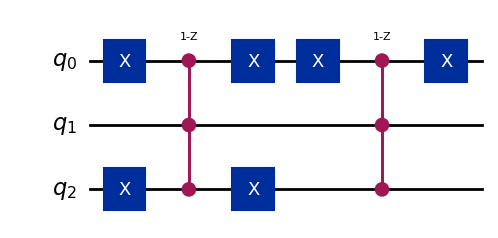

In [ ]:
"""
Vamos a crear 3 qubits que tiene 8 estados posibles

El oráculo debe marcar esos
- |010⟩ representa el 2
- |110⟩ representa el 6

Entonces en el espacio de 8 combinaciones,
vamos a encontrar esos dos números.
"""
estados_marcados = ["010", "110"]

oraculo = oraculo_grover(estados_marcados)

# Se grafica con matplotlib (mpl) e "idp"
#   para mejorar la legibilidad visual
oraculo.draw(output="mpl", style="iqp")

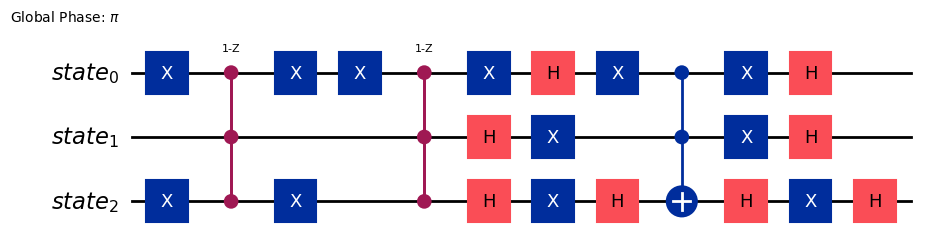

In [38]:
"""
Se usa GroverOperator para recibir un oráculo cuántico como entrada.
Devuelve un cto. completo de grover que incluye:

- El oráculo con los estados de solución marcados.
- El difusor que amplifica las probabilidades de esos estados.

Se crea la iteración completa del algoritmo de Grover.
"""
grover_op = GroverOperator(oraculo)

"""
Con decompose, podemos ver las compuertas intermedias
que se crearon.
"""
grover_op.decompose().draw(output="mpl", style="iqp")

In [39]:
"""
Se tiene que grover_op es una iteración completa del
    algoritmo de grover (oráculo mas difusión).

En cada iteración se amplifica la probabilidad de los estados marcados.
Pero si se aplica mas de la cuenta, la probabilidad baja.
Hay que encontrar el punto medio.
"""

m_estados_solucion = len(estados_marcados)
n_estados_posibles = 2**grover_op.num_qubits

theta = math.sqrt(m_estados_solucion / n_estados_posibles)

optimo_operaciones = math.pi / (4 * math.asin(theta))

iteraciones_ideales = math.floor(
    optimo_operaciones
)

print(f"Iteraciones ideales: {iteraciones_ideales}")

Iteraciones ideales: 1


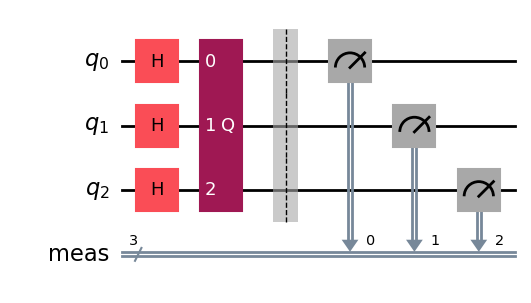

In [40]:
# Código completo Cto. Grover

# Creamos un cto. cuántico con el mismo número
#   de qbits que usa el grover operator
qc = QuantumCircuit(grover_op.num_qubits)

"""
Aplica la puerta Hadamard a todos los qubits.

Pasa cada qubit de |0⟩ a una superposición uniforme.
Esto crea la distribución equitativa entre los 2^n estados.
"""
qc.h(range(grover_op.num_qubits))

"""
Aplica el Grover operator la cantidad de veces necesaria 
    para maximizar la probabilidad de éxito.

Repitiendo el operator iteraciones_ideales de veces.

Esto realiza la amplificación de amplitudes para los estados solución.
"""
qc.compose(grover_op.power(iteraciones_ideales), inplace=True)

"""
Por último medimos todos los qubits donde el sistema colapsa
a un estado clásico.

Es muy probable que el valor medido sea uno de los estados marcados.
"""
qc.measure_all()
qc.draw(output="mpl", style="iqp")

# Transpilación

Adaptar el programa de arquitectura clásica a cuántica. Así puede ser ejecutado en el backedn correcto.

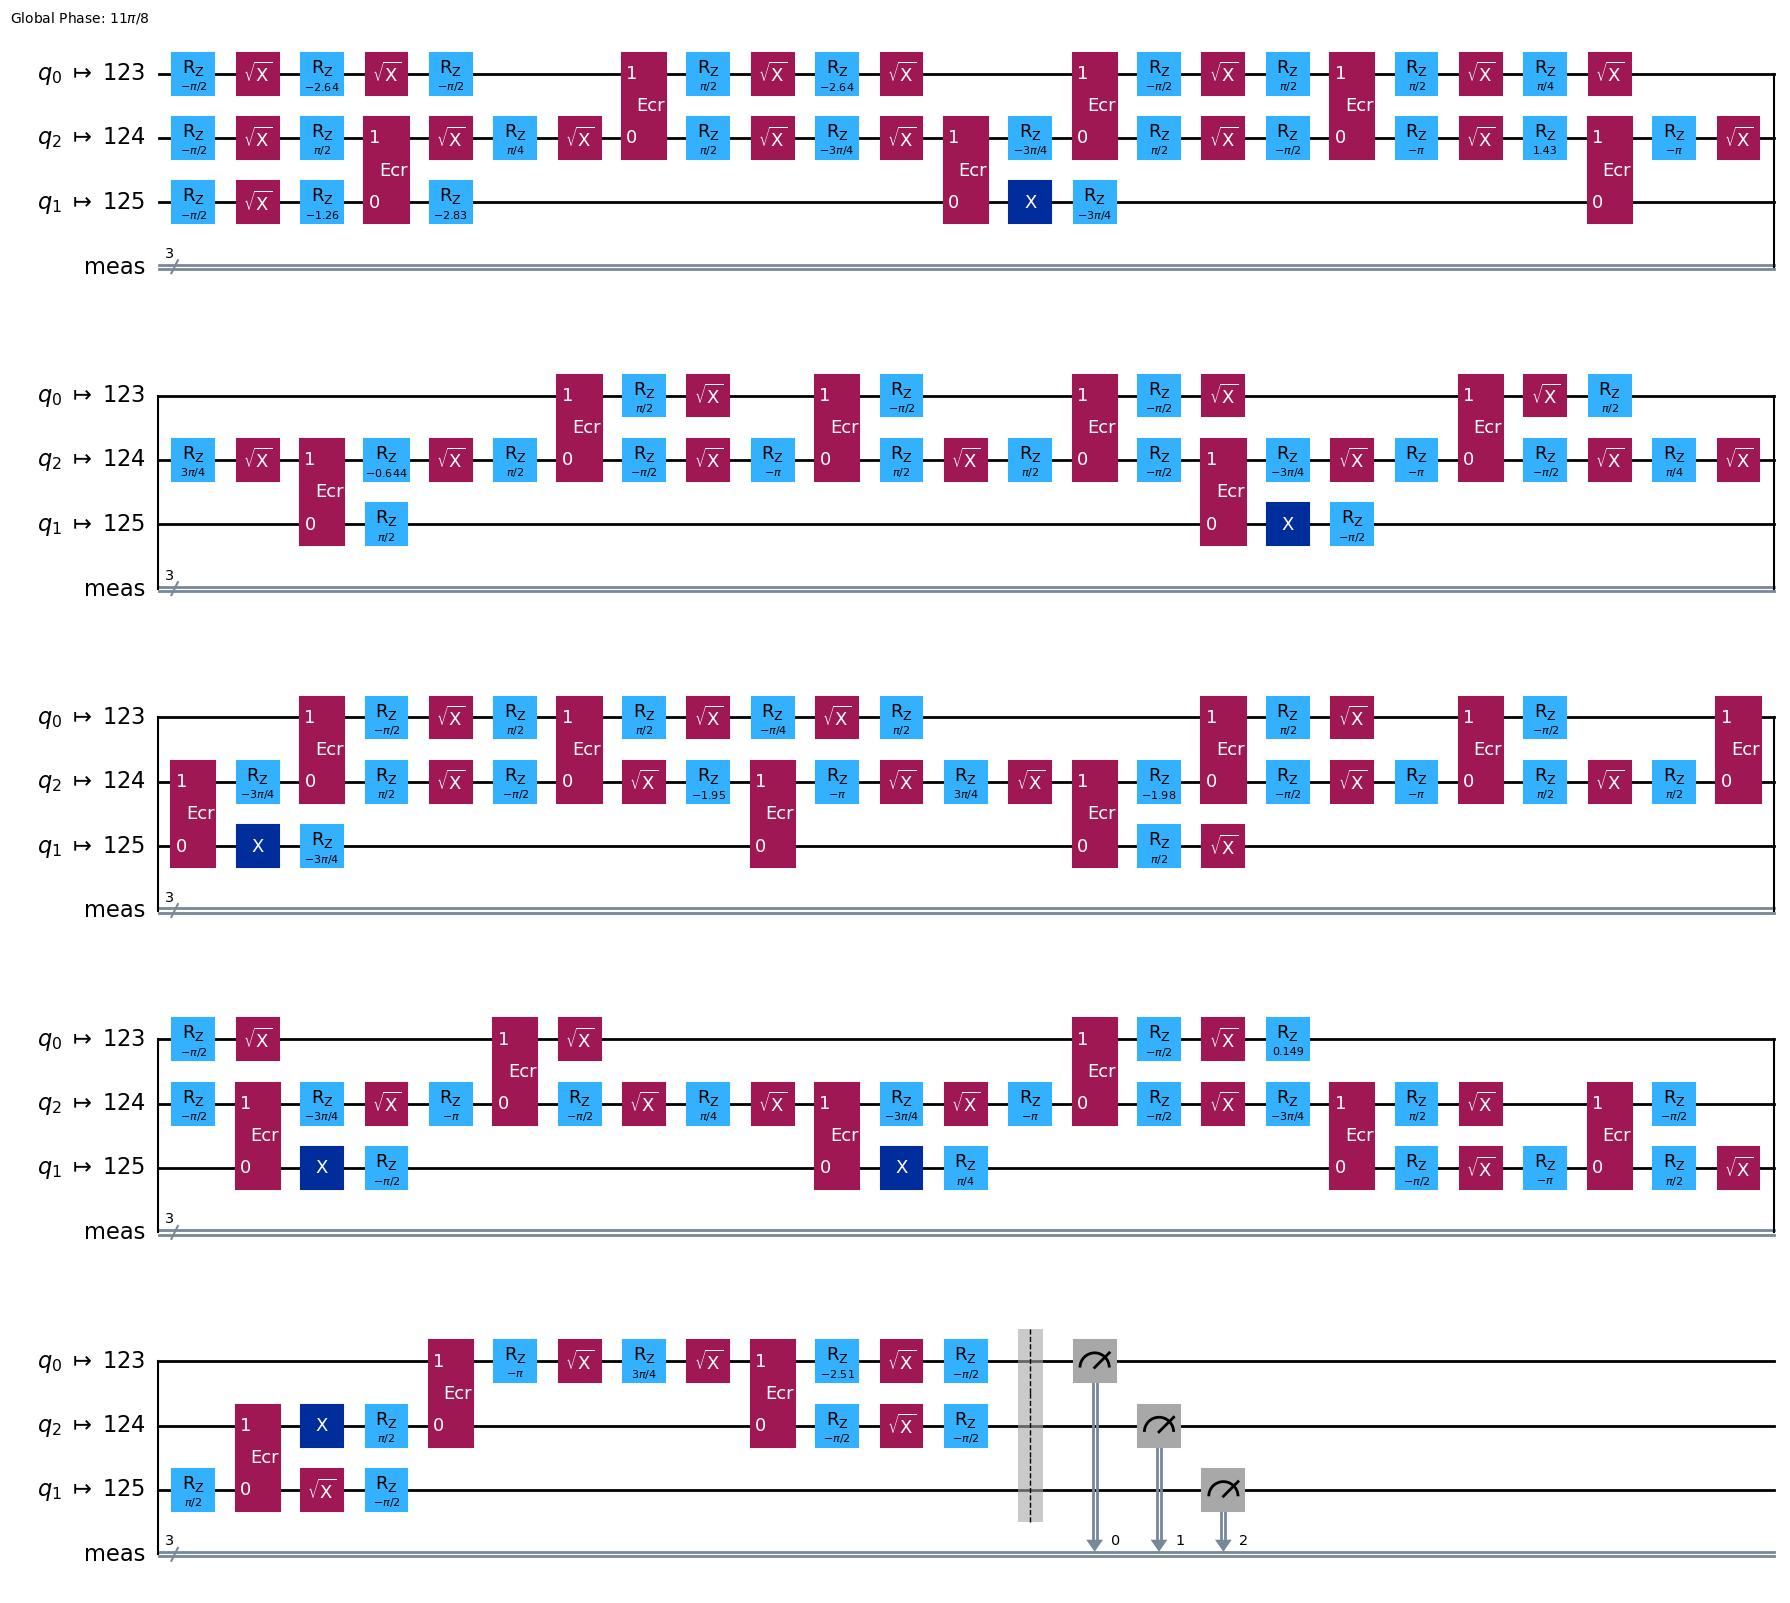

In [41]:
# Importar el generador de gestores de pasos (pass managers). Ya optimizado por Quiskit.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

"""
optimization_level=3 es el nivel más alto de optimización en Qiskit.
Es como un compilador.
"""
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Transpilación
circuit_isa = pm.run(qc)

# idle_wires=False oculta las líenas de qubits no utilizados
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

# Ejectar el cto. usando Quiskit Primitives

In [42]:
"""
Muestreo:
Sampler es la primitiva cuántica para medir frecuencias de salida.

El modo indica que debe tomar el backend que creamos.
"""
sampler = Sampler(mode=backend)

# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead

"""
Definimos el número de ejecuciones del cto.
Entre más, mejor será la distribución de salida.
"""
sampler.options.default_shots = 10500

# Ahora si se ejecuta el cto. transpilado
"""
El argumento debe ser una lista de primitivas unificadas (PUBs): 
    para Sampler, eso es una tupla (circuit, parámetros), 
    pero como no hay parámetros aquí, basta con [circuit_isa].
"""
result = sampler.run([circuit_isa]).result()

# Extrae la distribución de conteos 
#   (frecuencia de cada bitstring medido).
distribucion = result[0].data.meas.get_counts()

print(dist)

{'111': 378, '011': 3556, '100': 3545, '010': 580, '000': 586, '001': 367, '110': 1016, '101': 472}


# Ver los resultados

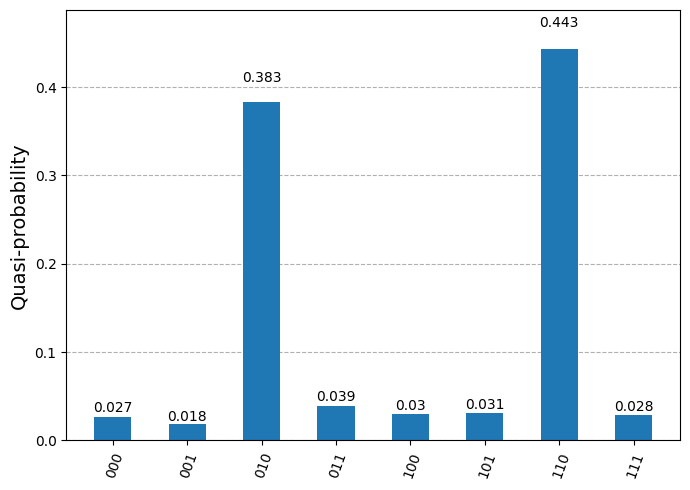

In [43]:
# Un histograma en el formato clásico
plot_distribution(distribucion)

Se puede ver que los estados que marcamos son en los que mas colapsan los qubits a partir de nuestra configuración de Grover.